<a href="https://colab.research.google.com/github/JackeyLove36/Brown_Course_Note/blob/main/CSCI1951Z_HW1_Ziao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to your first assignment! In this assignment, you will be learning about:

1. how to assess real-world deployments of algorithms for bias,
2. how to interpret the values of fairness measures and evaluate the efficacy of proposed fairness measures.
3. how simple interventions when training a model might affect the fairness as measured using different approaches

We will be using Google Colab Notebook for the first assignment. We will provide a few tips on how to use Colab and make sure you read them carefully!

☝ **Quick Colab Tips:**

*   Make sure you **create a copy** of the Colab before you start coding!!! (File->Save a copy in Drive). If you don't do this, you will lose everything when you close the page and we DON'T want that to happen to you!
*   Make sure you hit every play button that you need in previous cells, so that all functions & variables you need are defined.
*   If you don't want to click everything individually, you can click Runtime and you will find "Run Before", "Run After", or "Run All".
*   When you reload the page, the runtime restarts and all variables in the environment are cleared, so you will need to re-run cells.
*   If you make changes to a definition in an earlier cell, remember to run the cell to actually update the definition. Then remember to re-run the cells after, or else they will still be using the previous value.
*   For more tips on getting started, please take a look at this [video](https://www.youtube.com/watch?v=inN8seMm7UI&ab_channel=TensorFlow).

# Section 1: Analyzing a real-world scenario for sources of bias

We have discussed the different forms of bias that arise when designing a human-facing automated decision system. For reference, look at Figure 2 from the [NIST Special Publication](https://nvlpubs.nist.gov/nistpubs/SpecialPublications/NIST.SP.1270.pdf) on identifying and managing bias in AI.

In this question you will apply your understanding of statistical/computational biases to a real-world scenario. The goal is to identify potential sources of bias in the example and list them with justification. Make sure to distinguish whether the identified sources are likely to appear in the data collection/representation stage, the training/model building phase, or the inference/action stage of the data processing pipeline.

## The Scenario

Health care systems use automated tools to determine whether a patient should be admitted into an intensive "care management system" to cure what ails them. The idea is to determine which patients can benefit the most from being admitted to the system because it is expensive, and not everyone can be enrolled.

It is hard to know who will benefit the most, so the systems instead try to predict a proxy: who will incur the most health care costs. The idea is that if your health care costs are predicted to be large, you probably need intensive treatments to be cured, and so you're likely to benefit.

The algorithm that makes this prediction uses the following training data set:
input features for an individual are are a list of insurance claim data from the previous year. Each such claim consists of


1. demographic information (age, sex, but not race)
2. type of insurance (private, medicare, medicaid, hmo, etc, )
3. disease diagnosis (usually expressed in a standard code)
4. Procedures performed (X-rays, MRIs, surgeries, etc, each expressed with a specific code)
5. Medications
6. Costs

The goal is to predict the cost of care this year. Formally, this is a regression problem with a mix of numerical and categorical variables, and a numeric output.

**Question:** For each category of bias (refer to the NIST figure), discuss what specific biases might arise in this scenario and how. (6-9 sentences per scenario)

**Solution**

In my perspectives, measurement bias in the category of statistical or computational bias would emerge. According to the explanation in NIST publication, measurement bias usually arises when features and labels are proxies for desired quantities, potentially leaving out important factors or introducing group or input-dependent noise that leads to differential performance. Therefore, considering that if health care systems collect the demographic information consisting of only age and sex and no other information, rural and low-income populations would not be predicted accurately. Because the dataset is mainly consisting of insurance claims from urban areas or affluent neighborhoods. Normally, rural or low-income populations face significant challenges to accessing healthcare, including the ability to purchase healthcare insurance or afford healthcare services. The lack of the access from these populations would lead to underrepresentation or complete absence of healthcare claims in the dataset used for predictive modeling. Therefore, I think that health care systems should collect more demographic information such as race and geographic region to reduce the influence of measurement bias.

(检查）


















#Section 2: Experimenting with the ways in which design choices affect fairness

### Installation

In [156]:
!pip install scikit-learn --quiet
!pip install folktables --quiet

In [157]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from folktables import ACSDataSource, ACSPublicCoverage

## Section 2a: How do we measure fairness?

In the task below, we are building a model to predict public healthcare coverage based on attributes of the individual such as age and sex. We will explore different measurements of fairness and see how they compare and contrast.

### Dataset and Preprocessing

In this part of the assignment, you will be working with a dataset from [Folktables](https://github.com/zykls/folktables), a Python package that provides access to datasets derived from the US Census. The data provided by this library is sourced from the [American Community Survey](https://www.census.gov/programs-surveys/acs), a demographics survey program that gathers information about individuals' educational attainment, income, employment, demographic information, etc. This is particularly useful for measuring fairness in machine learning models as you will see later on this the next section.

First, you will need download and process a dataset from California 2018. We have provided you with the code which handles preprocessing and train-test splitting. In the context of this assignment, you will be working with the `ACSPublicCoverage` prediction task as [defined by Folktables](https://github.com/socialfoundations/folktables#prediction-tasks-in-folktables).

*   This is a binary classification task that asks you to predict whether a person has a public coverage or not based on the given a set of features such as age, sex, race, and different types of disabilities.
*   One of the features used in prediction is race which is a sensitive attribute and ideally should not have a correlation with the prediction. Your goal is utilize different techniques to make your model more fair in its prediction.

Let us begin by observing the dataset. You might find the [Data Dictionary](https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2018.pdf) of the [ACS PUMS documentation](https://www.census.gov/programs-surveys/acs/microdata/documentation.html) helpful when interpreting the feature codings.

In [158]:
from folktables import ACSDataSource, ACSPublicCoverage

# import data source form ACS
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
prediction_task = ACSPublicCoverage

# gather columns defined in the ACSPublicCoverage prediction task
features, label, group = prediction_task.df_to_numpy(acs_data)

# aggregate features and target variable into the same dataframe
acs_public_coverage_data = acs_data[prediction_task.features
                               + [prediction_task.target]]

###### Data summary ######
print(acs_public_coverage_data.head())
print("features used for predictions: "   + str(prediction_task.features))
print("group membership variable: "       + str(prediction_task.group))
print("the target variable of interest: " + str(prediction_task.target))

   AGEP  SCHL  MAR  SEX  DIS  ESP  CIT  MIG  MIL  ANC  NATIVITY  DEAR  DEYE  \
0    30  14.0    1    1    2  NaN    1  3.0  4.0    1         1     2     2   
1    18  14.0    5    2    2  NaN    1  1.0  4.0    1         1     2     2   
2    69  17.0    1    1    1  NaN    1  1.0  2.0    2         1     2     2   
3    25   1.0    5    1    1  NaN    1  1.0  4.0    1         1     1     2   
4    31  18.0    5    2    2  NaN    1  1.0  4.0    1         1     2     2   

   DREM    PINCP  ESR  ST  FER  RAC1P  PUBCOV  
0   2.0  48500.0  6.0   6  NaN      8       1  
1   2.0      0.0  6.0   6  2.0      1       2  
2   2.0  13100.0  6.0   6  NaN      9       1  
3   1.0      0.0  6.0   6  NaN      1       1  
4   2.0      0.0  6.0   6  2.0      1       1  
features used for predictions: ['AGEP', 'SCHL', 'MAR', 'SEX', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'PINCP', 'ESR', 'ST', 'FER', 'RAC1P']
group membership variable: RAC1P
the target variable of int

As you can see, this summary doesn't really give us any information more than what attributes are used in the prediction task or what the prediction target is. One simple way to better our understanding is to visualize the distribution of some features of interest such as group membership attributes or the target label. We will explore both possibilities here.

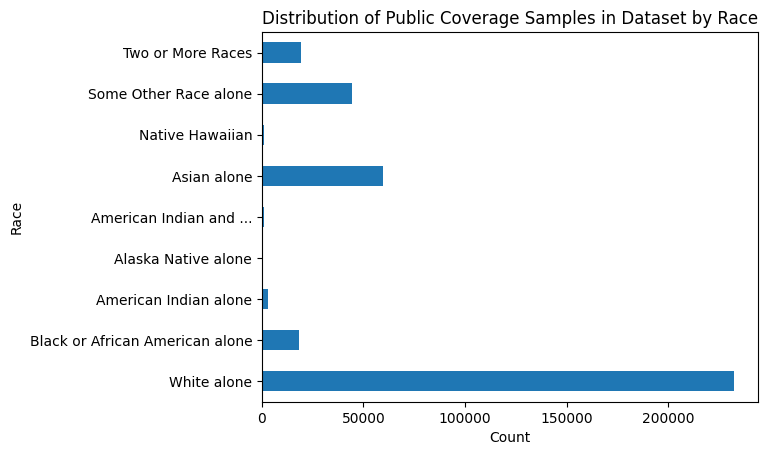

In [159]:
import matplotlib.pyplot as plt

race_coding = [
    'White alone',
    'Black or African American alone',
    'American Indian alone',
    'Alaska Native alone',
    'American Indian and ...',    # American Indian and Alaska Native tribes specified;
                                  # or American Indian or Alaska Native, not specified
                                  # and no other races
    'Asian alone',
    'Native Hawaiian',            # Native Hawaiian and Other Pacific Islander alone
    'Some Other Race alone',
    'Two or More Races']

ax = (acs_public_coverage_data
      .groupby([prediction_task.group])
      .size()
      .set_axis(race_coding)
      .plot(kind='barh')
)

ax.set_xlabel('Count')
ax.set_ylabel('Race')
ax.set_title('Distribution of Public Coverage Samples in Dataset by Race')

plt.show()

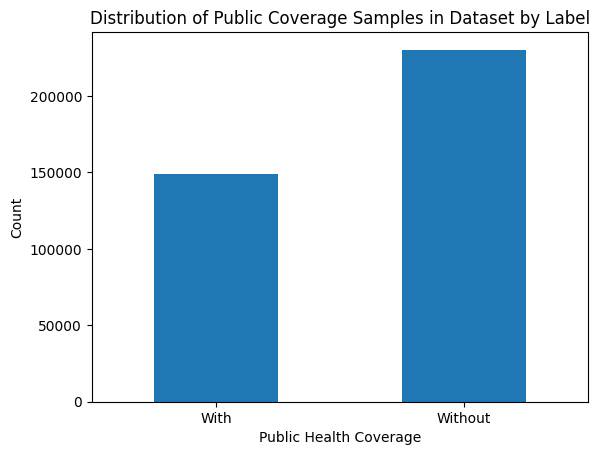

In [160]:
health_coverage_coding = [
    'With',
    'Without']

ax = (acs_public_coverage_data
      .groupby([prediction_task.target])
      .size()
      .set_axis(health_coverage_coding)
      .plot(kind='bar', rot=0)
)

ax.set_xlabel('Public Health Coverage')
ax.set_ylabel('Count')
ax.set_title('Distribution of Public Coverage Samples in Dataset by Label')

plt.show()

**Question:** What do you observe when it comes to the distribution of race and public health coverage? Take a moment to think about how this might affect the model's performance and fairness. (4-6 sentences)

**Solution**

Firstly, from the figure in Distribution of Public Coverage Samples in Dataset by Label, we notice that there are more people without public health converage in the dataset. Then, from the figure in Distribution of Public Coverage Samples in Dataset by Race, we notice that White alone has the significant number of people with public health converage, and Asian alone as well as Some other race alone have comparatively large number of people with public health converage. However, marginalized racial and ethnic groups such as Black or African American alone, American Indian alone and Native Hawaiian have few of people with public health converage. Therefore, to predict public healthcare coverage using this model is inaccurate in prediction especially for marginalized racial and ethnic groups because of the component of the dataset. We have few datas related to marginalized racial and ethnic groups, which generate the underestimate of the healthcare costs for these groups and lead to inequitable resource allocation. Measurement bias arises and influences the fairness of this model, which aims to ensure equitable outcomes for all demographic groups.

(检查）






### Training

Here, you will define your training function with Logistic Regression. You can check out sklearn documentation for [Logistic Regression ](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)here.

We will be using the [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) and [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)when initializing the Logistic Regression model. You can read their documentations to learn more about these two functions.

In [161]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

def train(X_train, y_train):
  """
  Defines and trains a logistic regression model on the training data.

  Args:
    X_train (np.ndarray): Training inputs.
    y_train (np.ndarray): Training labels.

  Returns:
    sklearn.pipeline.Pipeline: trained model
  """
  clf = LogisticRegression()
  scaler = StandardScaler()
  model=make_pipeline(scaler,clf)
  model.fit(X_train,y_train)
  return model

### Evaluation: Independence, Separation, Sufficiency

In this section, you will implement three fairness measurements: independence, separation,
and sufficiency. With these three measurements, we can evalute how fair our model is in making predictions.

Here are how the measurements are calculated:

**Definition 1: Independence**

*Random variables $(A, R)$ satisfy independence if $A \perp R$*

Let $\text{independence} = \frac{P\{ \hat{Y} = 1\ | A = a\}}{P\{ \hat{Y} = 1\ | A = b\}}$

Then $A \perp R$ is equivalent to saying that $\text{independence} = 1$

Here, $\hat{Y}$ is our prediction from the model and $A$ is the feature we want to evaluate the independence against the prediction on.


In [162]:
def independence(y_hat, group):
  """
  Computes an independence metric between two specific groups.

  Args:
    y_hat (np.ndarray): Classifier predictions.
    group (np.ndarray): Array of indices corresponding to group membership.
      For this assignment, we will focus on comparing groups 1 and 2.
      These correspond to the 'White alone' and 'Black or African American'
      groups. Note that one can also compare different combinations of groups.

  Returns:
    float: independence measure
  """
  # TODO: compute independence
  conditional_above=np.sum((y_hat==False)&(group==1))/np.sum(group==1)
  conditional_below=np.sum((y_hat==False)&(group==2))/np.sum(group==2)
  independence_metric=conditional_above/conditional_below
  return independence_metric

**Definition 2: Separation**

*Random variables $(R, A, Y)$ satisfy separation if $R\perp A| Y$*

In the case of a binary classifier (what we are doing in this assignment, separation is equivalent to requiring for all groups $a,b$ the two constraints

$\text{Separation}_{\text{true positive}} = \frac{P\{ \hat {Y} = 1 | Y = 1, A = a\}} {P \{\hat{Y} = 1 | Y = 1, A = b\}}$
<br>
<br>
$\text{Separation}_{\text{false positive}} = \frac{P\{ \hat {Y} = 1 | Y = 0, A = a\}}{P \{\hat{Y} = 1 | Y = 0, A = b\}}$

In [163]:
def separation(y_hat, y_true, group):
  """
  Computes a separation metric between two specific groups.

  Args:
    y_hat  (np.ndarray): Classifier predictions.
    y_true (np.ndarray): Data labels.
    group  (np.ndarray): Array of indices corresponding to group membership.
      For this assignment, we will focus on comparing groups 1 and 2.
      These correspond to the 'White alone' and 'Black or African American'
      groups. Note that one can also compare different combinations of groups.

  Returns:
    float: separation true positive
    float: separation false positive
  """
  # TODO: compute separation
  separation_true_above=np.sum((y_hat==False)&(y_true==False)&(group==1))/np.sum((y_true==False)&(group==1))
  separation_true_below=np.sum((y_hat==False)&(y_true==False)&(group==2))/np.sum((y_true==False)&(group==2))
  separation_true=separation_true_above/separation_true_below
  separation_false_above=np.sum((y_hat==False)&(y_true==True)&(group==1))/np.sum((y_true==True)&(group==1))
  separation_false_below=np.sum((y_hat==False)&(y_true==True)&(group==2))/np.sum((y_true==True)&(group==2))
  separation_false=separation_false_above/separation_false_below
  return separation_true,separation_false

**Definition 3: Sufficiency**

*We say the random variables $(R, A, Y)$ satisfy sufficiency if $Y\perp A | R$*

In a binary case where $Y \in \{0, 1\}$, a random variable $R$ is sufficient for $A$ if and only if for all groups, $a,b$ and all values $r$ in the support of $R$, we have

$\text{sufficiency} = \frac{P\{Y = 1 | R = r, A = a\}}{P\{Y = 1 | R = r, A = b\}}$

When we replace $R$ by a binary predictor $\hat{Y}$, we recognize this condition as requiring a positive/negative predictive values across all groups.

In [164]:
def sufficiency(y_hat, y_true, group):
  """
  Computes a sufficiency metric between two specific groups.

  Args:
    y_hat  (np.ndarray): Classifier predictions.
    y_true (np.ndarray): Data labels.
    group  (np.ndarray): Array of indices corresponding to group membership.
      For this assignment, we will focus on comparing groups 1 and 2.
      These correspond to the 'White alone' and 'Black or African American'
      groups. Note that one can also compare different combinations of groups.

  Returns:
    float: sufficiency metric
  """
  # TODO: compute sufficiency
  sufficiency_above=np.sum((y_true==False)&(y_hat==False)&(group==1))/np.sum((y_hat==False)&(group==1))
  sufficiency_below=np.sum((y_true==False)&(y_hat==False)&(group==2))/np.sum((y_hat==False)&(group==2))
  sufficiency=sufficiency_above/sufficiency_below
  return sufficiency

Here let's define an evaluation function based on our three implementations of fairness measurement!

In [165]:
def eval(yhat, y_test, group_test, model_title):
  print("Results from the " + model_title + " model: ")
  print("the indepence of prediction and group is ", independence(yhat, group_test))
  true_s, false_s = separation(yhat, y_test, group_test)
  print("the true positive separation is ", true_s)
  print("the false positive separation is ", false_s)
  print("the sufficiency of the prediction and the group is", sufficiency(yhat, y_test, group_test))

Please feel free to use the following dummy data and predictions to unit test your own implementation. We encourage that you grab a pen and verify with simple calculation that this makes sense!

The expected results:

```
Results from unit-testing model:
the indepence of prediction and group is  0.6666666666666667
the true positive separation is  0.75
the false positive separation is  0.6666666666666666
the sufficiency of the prediction and the group is 0.75
```

In [166]:
yhat_example       = np.asarray([True, True, False, False,  True, False, False, False,  True, True])
y_test_example     = np.asarray([True, True, True,  False, False, False, False,  True, False, True])
group_test_example = np.asarray([   1,    1,    1,      1,     1,     2,     2,     2,     2,    2])

eval(yhat_example, y_test_example, group_test_example, "unit-testing")

Results from the unit-testing model: 
the indepence of prediction and group is  0.6666666666666667
the true positive separation is  0.75
the false positive separation is  0.6666666666666666
the sufficiency of the prediction and the group is 0.75


#### The Full Workflow

Here, let's connect the whole pipeline with training and see how fair our model is!

You will
1. Do a train_test_split on the dataset on a 80-20 ratio with a `random_state = 0`
2. Train your Linear Regression Model
3. Use the trained model to make prediction on the test dataset
4. Evalute the model with fairness measurements.

In [167]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)
model = train(X_train, y_train)
yhat = model.predict(X_test)

eval(yhat, y_test, group_test, "baseline")

Results from the baseline model: 
the indepence of prediction and group is  1.1340215172681893
the true positive separation is  1.0270629991126885
the false positive separation is  1.1547843098410184
the sufficiency of the prediction and the group is 1.2359069407697714


### Interpretation

**Question**: Please interpret the values for each fairness measurements for the model's prediction in the context of public healthcare coverage (4-6 sentences).


**Solution**
With the indepence value of prediction and group of 1.134, this suggests that the model's predictions are not significantly influenced by the demographic characteristics, such as race or ethnicity, which is desirable in ensuring equitable treatment across diverse populations. Also, the true positive separation is 1.027, which indicates minimal disparity, suggesting that the model performs well in correctly identifying individuals with positive outcomes across different demographic groups. In the context of public healthcare coverage, this indicates relatively consistent performance in correctly identifying individuals who require healthcare coverage or interventions, regardless of their race or ethnicity. Furthermoe, the false positive separation is 1.155, a value slightly above 1, implying a slight disparity, which shows that certain demographic groups may be more prone to being falsely identified as needing healthcare coverage. Finally, the sufficiency of the prediction and the group is 1.236, implying that the model adequately considers the demographic characteristics in its predictions, which ensures that individuals from different demographic groups receive appropriate healthcare coverage or interventions tailored to their specific needs.

(检查）


**Question:** Predictions for public healthcare coverage are often used to inform government resource allocations and policy decisions in providing health services.

In this scenario, explain what would be considered a "fair" outcome form the model's prediction. Based on the the measurement values from above, would you consider your model to meet your fairness requirement? (5-8 sentences)

**Solution**


From my perspectives, I think that a "fair" outcome from the model's prediction should entail equitable distribution of resources and interventions to demographic groups. This includes that to make sure that individuals receive the most accurate healthcare coverage based on their needs without consideration of race or ethnicity. Therefore, we should expect that the tranied model should not predict systematically favor or disadvantage any particular demographic group and can accurately indetify the real needs of individuals. Based on the measurement values from above, I think that the model meet the overall fairness requirements because the Independence of Prediction and Group value indicates a relatively low level of influence of demographic characteristics on the model's predictions and the True Positive Separation value indicates minimal disparity in correctly identifying individuals with positive outcomes to different demographic groups. Furthermore, the slightly higher False Positive Separation value suggests that a slight disparity in incorrectly identifying individuals as needing healthcare coverage. Therefore, ongoing monitoring and refinement may be necessary to address any remaining disparities and ensure truly equitable resource allocations and policy decisions.


(检查）


#### Sufficiency and Model Performance

We now explore the correlation between sufficiency and model performance by constructing three different logistic regression models of varying accuracy (low / medium / high). Then we observe the sufficiency scores for each model.

Fill in the following three functions to train three versions of `LogisticRegression` models. They should look similar to the `train()` function. Each model will be trained slightly differently:


1.   Train this model without a bias term in the weights. Check the [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for how to do this. This model should achieve the worse performance of the three.
2.   Train this model like normal on only the first 5000 elements of the dataset.
3.   Train this model like normal, using the entire training dataset. This model should achieve the best performance of the three.

In [168]:
def fit_model_1(X_train, y_train):
  """
  Defines and trains a logistic regression model on the training data.

  This classifier should be constrained to not include a bias/intercept.
  Once again, the docs may be useful
  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

  Args:
    X_train (np.ndarray): Training inputs.
    y_train (np.ndarray): Training labels.

  Returns:
    sklearn.pipeline.Pipeline: trained model
  """

  # TODO: train model
  scaler = StandardScaler()
  clf=LogisticRegression(fit_intercept=False)
  model=make_pipeline(scaler,clf)
  model.fit(X_train,y_train)
  return model

In [169]:
def fit_model_2(X_train, y_train):
  """
  Defines and trains a logistic regression model on the training data.

  This classifier should only be trained on the first 5000 datapoints.

  Args:
    X_train (np.ndarray): Training inputs.
    y_train (np.ndarray): Training labels.

  Returns:
    sklearn.pipeline.Pipeline: trained model
  """

  # TODO: train model
  X_train_subset = X_train[:5000]
  y_train_subset = y_train[:5000]
  scaler = StandardScaler()
  clf=LogisticRegression()
  model=make_pipeline(scaler,clf)
  model.fit(X_train_subset,y_train_subset)
  return model

In [170]:
def fit_model_3(X_train, y_train):
  """
  Defines and trains a logistic regression model on the training data.

  Args:
    X_train (np.ndarray): Training inputs.
    y_train (np.ndarray): Training labels.

  Returns:
    sklearn.pipeline.Pipeline: trained model
  """
  # TODO: train model
  scaler = StandardScaler()
  clf=LogisticRegression()
  model=make_pipeline(scaler,clf)
  model.fit(X_train,y_train)
  return model

In [171]:
# Fit models
model_1 = fit_model_1(X_train, y_train)
model_2 = fit_model_2(X_train, y_train)
model_3 = fit_model_3(X_train, y_train)

# Prediction of models
yhat_1 = model_1.predict(X_test)
yhat_2 = model_2.predict(X_test)
yhat_3 = model_3.predict(X_test)

# Accuracy of models
accuracy_1 = np.mean(y_test[yhat_1])
accuracy_2 = np.mean(y_test[yhat_2])
accuracy_3 = np.mean(y_test[yhat_3])

print(f"Model 1:\n  Accuracy: {accuracy_1:.3f}\n  Sufficiency: {sufficiency(yhat_1, y_test, group_test):.3f}")
print(f"Model 2:\n  Accuracy: {accuracy_2:.3f}\n  Sufficiency: {sufficiency(yhat_2, y_test, group_test):.3f}")
print(f"Model 3:\n  Accuracy: {accuracy_3:.3f}\n  Sufficiency: {sufficiency(yhat_3, y_test, group_test):.3f}")

Model 1:
  Accuracy: 0.535
  Sufficiency: 1.123
Model 2:
  Accuracy: 0.650
  Sufficiency: 1.233
Model 3:
  Accuracy: 0.666
  Sufficiency: 1.236



**Question:** What correlation between accuracy and sufficiency do you observe? What are the implications of such a correlation in the context of standard machine learning practices? Why might imposing sufficiency as a constraint be helpful or not? (4-6 sentences)

**Solution**

From the above data, we can see that there exists a positive correlation between accuracy and sufficiency because as the accuracy increases, the sufficiency has a tendency to augment. Considering this correlation in the context of standard machine learing practices, I think that this correlation implies that models achieving higher accuracy are more effective at incorporating demographic characteristics into their predictions. But we need also to notice that while higher sufficiency scores indicate better fairness in predictions, these values do not guarantee equitable outcomes, especially if the model is biased or trained on biased data. I think that imposing sufficiency as a constraint is helpful in ensuring that predictive models consider demographic characteristics and mitigate biases, which helps practitioners to prioritize fairness and equity in predictive modeling. However, we can balance sufficiency with other performance metrics and interpretability requirements to develop better models with better fairness and accuracy.

(检查）

## Section 2a (continued): Fairness Metrics Continued

*Because we will be using these metrics in the next assignment, we also introduce the following fairness metrics which are commonly used.*


#### Statistical Parity Difference
Statistical Parity Difference (SPD) measures the difference that the majority and protected classes receive a favorable outcome. This measure must be equal to 0 to be fair.

SPD is measured by the following equation:

$$\text{SPD} = P(\hat{Y}=1 | A = \text{minority}) - P(\hat{Y}=1 | A = \text{majority}).$$

In [172]:
def spd(sensitive_attribute, dataset, predicted_labels, majority_class, minority_class):
    """
    Calculate the Statistical Parity Difference (SPD) between majority and minority classes based on predicted labels.

    Parameters:
    - sensitive_attribute (str): Name of the column representing the sensitive attribute.
    - dataset (pd.DataFrame): The dataset containing the sensitive attribute and true outcome variable.
    - predicted_labels (pd.Series): Predicted labels for the outcome variable.
    - majority_class: Value representing the majority class in the sensitive attribute.
    - minority_class: Value representing the minority class in the sensitive attribute.

    Returns:
    - spd (float): Statistical Parity Difference between majority and minority classes.
    """
    # TODO: Compute the spd value
    major_indic=dataset[sensitive_attribute]==majority_class
    minor_indic=dataset[sensitive_attribute]==minority_class
    p_left=np.sum((predicted_labels[minor_indic]==False))/np.sum(dataset[sensitive_attribute]==minority_class)
    p_right=np.sum((predicted_labels[major_indic]==False))/np.sum(dataset[sensitive_attribute]==majority_class)
    spd_val=p_left-p_right
    return spd_val

#### Disparate Impact
Disparate Impact (DI) compares the proportion of individuals that receive a favorable outcome for two groups, a majority group and a minority group.

Disparate impact is measured by the following equation:

$$\text{DI} = \frac{P(\hat{Y}=1 | A = \text{minority})}{P(\hat{Y}=1 | A = \text{majority})}.$$

In [173]:
def di(sensitive_attribute, dataset, predicted_labels, majority_class, minority_class):
    """
    Calculate the Disparate Impact (DI) between majority and minority classes based on predicted labels.

    Parameters:
    - sensitive_attribute (str): Name of the column representing the sensitive attribute.
    - dataset (pd.DataFrame): The dataset containing the sensitive attribute and true outcome variable.
    - predicted_labels (pd.Series): Predicted labels for the outcome variable.
    - majority_class: Value representing the majority class in the sensitive attribute.
    - minority_class: Value representing the minority class in the sensitive attribute.

    Returns:
    - di (float): Disparate Impact between majority and minority classes.
    """
    # TODO: Compute the DI value
    major_indic=dataset[sensitive_attribute]==majority_class
    minor_indic=dataset[sensitive_attribute]==minority_class
    p_above=np.sum((predicted_labels[minor_indic]==False))/np.sum(dataset[sensitive_attribute]==minority_class)
    p_below=np.sum((predicted_labels[major_indic]==False))/np.sum(dataset[sensitive_attribute]==majority_class)
    di_val=p_above/p_below
    return di_val

#### Equal Opportunity Difference

Equal Opportunity Difference (EOD) measures the deviation from the equality of opportunity, which means that the same proportion of each population receives the favorable outcome.

EOD is measured by the following equation:

$$\text{EOD} = P(\hat{Y}=1 | A = \text{minority}, Y=1) - P(\hat{Y}=1 | A = \text{majority}, Y=1).$$

In [174]:
def eod(sensitive_attribute, predictions, dataset, true_labels, majority_class, minority_class):
    """
    Calculate the Equal Opportunity Difference (EOD) measure.

    Parameters:
    - sensitive_attribute: The column name of the sensitive attribute in the dataset.
    - predictions: Predictions made by the model.
    - dataset: The dataset containing the sensitive attribute and the outcome variable.
    - outcome_variable: The column name of the outcome variable in the dataset.
    - majority_class: The majority class label.
    - minority_class: The minority class label.

    Returns:
    - eod_value: The Equal Opportunity Difference measure.
    """
    # TODO: Compute the eod value
    major_indic=dataset[sensitive_attribute]==majority_class
    minor_indic=dataset[sensitive_attribute]==minority_class
    p_left=np.sum((true_labels[minor_indic]==False)&(predictions[minor_indic]==False))/np.sum(true_labels[minor_indic]==False)
    p_right=np.sum((true_labels[major_indic]==False)&(predictions[major_indic]==False))/np.sum(true_labels[major_indic]==False)
    eod_value=p_left-p_right
    return eod_value

#### Average Absolute Odds Difference

Average Absolute Odds Difference (AAOD) measures bias by using the false positive rate and true positive rate.

AAOD is measured by the following equation:

$$\text{AAOD} = \frac{1}{2}\left[|FPR_{A=\text{minority}} - FPR_{A=\text{majority}}| + |TPR_{A=\text{minority}} - TPR_{A=\text{majority}}|\right].$$

Here, FPR and TPR refers to the false positive rate and true positive rate respectively.

The following equations define FPR and TPR:
$$FPR = \frac{FP}{FP + TN}$$
$$TPR = \frac{TP}{TP + FN}$$
where TP, FP, TN, and FN are the number of true positives, false positives, true negatives, and false negatives respectively.

In [175]:
def aaod(sensitive_attribute, predictions, dataset, true_labels, majority_class, minority_class):
    """
    Calculate the Average Absolute Odds Difference (AAOD) to measure bias.

    Parameters:
    - sensitive_attribute (str): The name of the sensitive attribute in the dataset.
    - predictions (pd.Series): The predicted values.
    - dataset (pd.DataFrame): The dataset containing the sensitive attribute, predictions, and outcome variable.
    - outcome_variable (str): The name of the outcome variable in the dataset.
    - majority_class (int): The label of the majority class.
    - minority_class (int): The label of the minority class.

    Returns:
    - float: The calculated Average Absolute Odds Difference (AAOD).
    """
    # TODO: Compute the aaod value
    major_indic = dataset[sensitive_attribute] == majority_class
    minor_indic = dataset[sensitive_attribute] == minority_class
    tp_majority = np.sum((predictions[major_indic] == True) & (true_labels[major_indic] == True))
    fp_majority = np.sum((predictions[major_indic] == True) & (true_labels[major_indic] == False))
    tn_majority = np.sum((predictions[major_indic] == False) & (true_labels[major_indic] == False))
    fn_majority = np.sum((predictions[major_indic] == False) & (true_labels[major_indic] == True))
    tp_minority = np.sum((predictions[minor_indic] == True) & (true_labels[minor_indic] == True))
    fp_minority = np.sum((predictions[minor_indic] == True) & (true_labels[minor_indic] == False))
    tn_minority = np.sum((predictions[minor_indic] == False) & (true_labels[minor_indic] == False))
    fn_minority = np.sum((predictions[minor_indic] == False) & (true_labels[minor_indic] == True))
    fpr_minority=fp_minority/(fp_minority+tn_minority)
    tpr_minority=tp_minority/(tp_minority+fn_minority)
    fpr_majority=fp_majority/(fp_majority+tn_majority)
    tpr_majority=tp_majority/(tp_majority+fn_majority)
    aaod_value=0.5*(np.abs(fpr_minority-fpr_majority)+np.abs(tpr_minority-tpr_majority))
    return aaod_value

**Question:** To analyze these fairness measures mathematically, please provide the range of values (i.e., the upper and lower bounds) for each metric above (Statistical Parity Difference, Disparate Impact, and Equal Opportunity Difference).

Additionally, for the metric, specify the value when the model achieves "perfect" fairness. (3-5 sentences)



**Solution**

The range of value of Statistical Parity Difference is from -1 to 1 because the range of each probability is from 0 to 1.

$$\text{SPD}\in [-1,1]$$

The range of value of Disparate Impact is from 0 to $\infty$ because the range of each probability is from 0 to 1, as the denominator teads to be 0, the value of Disparate Impact tends to $\infty$.

$$\text{DI}\in [0,\infty)$$

The range of value of Equal Opportunity Difference is from -1 to 1 because the range of each probability is from 0 to 1.

$$\text{EOD}\in [-1,1]$$

When it comes to "perfect" fairness, Statistical Parity Difference reaches perfect fairness at 0, Disparate Impact reaches perfect fairness at 1, and Equal Opportunity Difference reaches perfect fairness at 0.


（检查）

**Question:** Please describe  a scenario in which one fairness metric would be more suitable than another for assessing biases in algorithmic systems. You're welcome to reference real life applications to illustrate your point. (4-6 sentences)

**Solution**

From my perspectives, I think that one scenario where Statistical Parity Difference (SPD) is more suitable than Equal Opportunity Difference (EOD) as a fairness metric when it comes to the admission decisions for educational programs. For example, considering a university's admissions process where the goal is to ensure fairness and equal opportunity for all applicants, regardless of their demographic characteristics. By calculating SPD, the university can directly measure the difference in admission rates between various demographic groups, such as gender or ethnicity. We can see that SPD allows the university to identify and address disparities in admission rates, which ensures that all qualified applicants have an equal chance of being admitted regardless of their demographic backgrounds. However, EOD would also be applied in this scenario to assess disparities in the true positive rates (admission rates) between different demographic groups. But, this is not directly address the university's goal of ensuring equal chances among the overall applicants rather than only admitted students.

（检查）


**Question:**
How does each of the fairness metric above relate to the measures of Independence, Separation, and Sufficiency? (2-4 sentences)

**Solution**

For Statistical Parity Difference (SPD), it related to the measurses of Independence by assessing whether outcomes are independent of sensitive attributes, related to Separation by comparing the distribution of outcomes across different demographic groups, and not directly related to Sufficiency. For Disparate Impact (DI), I think it is related to Independence by evaluating the impact of protected attributes on decision outcomes, related to Separation by quantifying disparities in outcomes between different groups, and related to Sufficiency by assessing whether outcomes provide sufficient opportunities for all groups. For Equal Opportunity Difference (EOD), it is related to Separation by assessing whether decision outcomes are independent of sensitive attributes, but I don't think EOD is directly related to Independence and Sufficiency. Finally, for Average Absolute Odds Difference (AAOD), I think it is related to Separation by measuring disparities in false positive and true positive rates between different demographic groups, but it is unrelated to Independence and Sufficiency.

（检查）

# Section 3: Analyzing a particular mathematical notion of fairness

In our exploration of fairness measures we've been considering how to evaluate the fairness of a binary classifier that produces a 0-1 output.

In various exploratory data mining tasks the goal is to *cluster* a collection of objects into groups and determine whether the groups have some meaningful structure.

Formally, we are given a set of $n$ points, where each point is represented by a $d$-dimensional feature vector $x \in R^d$. We define the *distance* between two points as the Euclidean distance between them:

$ d(x,y) = \sqrt{\sum_{i=1}^d (x_i - y_i)^2}$

And then we define the $k$-means problem as:

Partition the points into $k$ clusters $C_1, \dots, C_k$ such that the sum of squared distance from each point to its cluster center is minimized, where the center of a cluster is defined as the centroid of the cluster:  
$\mu(C) = \sum_{x \in C} x/|C|$
where $|C|$ is the number of points in the cluster. More precisely, the goal is to find $C_1, \dots, C_k$ such that

$\sum_{j=1}^k \sum_{x \in C_j} d^2(x, \mu(C_j))$ is minimized.

Now consider a "fair" equivalent of this problem. Now each point $x$ also has a color $g(x)$. For any clustering we can write down the fraction of points within a cluster having a particular color.

Then the goal is to make sure these fractional values for each cluster match the overall proportions of colors. For example, if we have 15 points of which 5 are red and 10 are blue, and we want to cluster them into 5 clusters, then in each cluster there should be 1 red and 2 blue points.

Consider two scenarios in which one might wish to cluster points.

1. Each point encodes different kinds of qualifications. The clusters represent people with similar qualifications. The "color" of a point is a gender encoding. The goal of the clustering is to group people into categories to target them with different kinds of job ads.

2. Each point represents the location of a voter in a state. The clusters represent voting districts for a state assembly. The "color" of a point is the person's registered political affiliation (assume that there are two parties).

**Question:** Assess the degree to which the fairness measure eliminates any form of bias that one might be concerned with in the scenarios described. (5-8 sentences)

**Solution**










(简答题）





# Section 4: Fairness Intervention Techniques

## Section 4a: Credit Scoring Case Study




The goal of the credit scoring case study is to explore the fairness metrics defined above in regards with two sensitive attribtues: customer age and residential status. The credit data contains variables customer ID, customer age, time at current address, residential status, employment status, customer income, time with bank, other credit card, average monthly balance, utilization rate, and the default status.

Inspired by https://research.google.com/bigpicture/attacking-discrimination-in-ml/

Credit data is from http://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

In [176]:
import pandas as pd

!pip install --upgrade --no-cache-dir gdown --quiet

!gdown --id 1QtIQZZZL1GMiSpHgFBiA7romdlVLcVbn

df = pd.read_csv('german_credit_data.csv', index_col=[0])
df.head()

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1QtIQZZZL1GMiSpHgFBiA7romdlVLcVbn
To: /content/german_credit_data.csv
100% 49.7k/49.7k [00:00<00:00, 57.8MB/s]


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


We remove the categories we don't need and clean the data before feeding it into the model.

In [177]:
# Data Cleaning & Processing
df0 = df.copy()
df0['Age<=40'] = (df0['Age'] <= 40).astype(int)
df0['status'] = (df0['Credit amount'] > 1500).astype(int)
df0['Sex'] = (df0['Sex'] == 'male').astype(int)

# Create a mapping dictionary
housing_dict = {'own': 0, 'free': 1, 'rent': 2}
saving_dict = {'little': 0, 'moderate':1, 'quite rich': 2, 'rich': 3}
checking_dict = {'little': 0, 'moderate':1, 'rich': 2}
purpose_dict = {'radio/TV': 0, 'education':1, 'furniture/equipment': 2, 'car': 3, 'business':4, 'domestic appliances':5, 'repairs':6, 'vacation/others':7}

# Use the map function to to convert categorial to numerical variables
df0['Housing'] = df0['Housing'].map(housing_dict)
df0['Saving accounts'] = df0['Saving accounts'].map(saving_dict)
df0['Checking account'] = df0['Checking account'].map(checking_dict)
df0['Purpose'] = df0['Purpose'].map(purpose_dict)
print('Initial Dataset')
display(df0.head())
display(df0.shape)
columns_to_drop = ['Credit amount', 'Age', 'Checking account']
df0.drop(columns=columns_to_drop, inplace=True)
df0 = df0[df['Saving accounts'].notna()]
print()
print('Preprocessed Dataset')
display(df0.head())
display(df0.shape)

Initial Dataset


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Age<=40,status
0,67,1,2,0,NaN,0.0,1169,6,0,0,0
1,22,0,2,0,0.0,1.0,5951,48,0,1,1
2,49,1,1,0,0.0,NaN,2096,12,1,0,1
3,45,1,2,1,0.0,0.0,7882,42,2,0,1
4,53,1,2,1,0.0,0.0,4870,24,3,0,1


(1000, 11)


Preprocessed Dataset


,Sex,Job,Housing,Saving accounts,Duration,Purpose,Age<=40,status
1,0,2,0,0.0,48,0,1,1
2,1,1,0,0.0,12,1,0,1
3,1,2,1,0.0,42,2,0,1
4,1,2,1,0.0,24,3,0,1
6,1,2,0,2.0,24,2,0,1


(817, 8)

We prepare our training and testing data.

In [178]:
# Independent features X
X = df0.iloc[:, :-1]
# Response feature y
y = df0.iloc[:, -1]

# prepare the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [179]:
print(X_train)

     Sex  Job  Housing  Saving accounts  Duration  Purpose  Age<=40
355    1    1        0              0.0        24        3        1
378    1    3        1              0.0        36        3        0
26     1    1        0              0.0         6        0        1
783    0    1        0              1.0        12        3        1
782    1    1        0              0.0        12        1        1
..   ...  ...      ...              ...       ...      ...      ...
934    0    2        0              0.0        12        0        1
232    1    2        0              1.0        12        0        1
759    1    2        0              0.0        12        3        1
675    0    3        2              0.0        30        0        1
831    0    2        2              0.0        18        3        1

[571 rows x 7 columns]


In [180]:
def compute_metrics(sensitive_attribute, predictions, dataset, true_labels, majority_class, minority_class, disp=True):
  metrics = {}

  # TODO: Fill out the metrics dictionary
  metrics['statistical parity difference']=spd(sensitive_attribute,dataset,predictions,majority_class,minority_class)
  metrics['disparate impact'] = di(sensitive_attribute,dataset,predictions,majority_class,minority_class)
  metrics['equal opportunity difference'] = eod(sensitive_attribute, predictions, dataset, true_labels, majority_class, minority_class)
  metrics['average absolute odds difference'] =aaod(sensitive_attribute, predictions, dataset, true_labels, majority_class, minority_class)

  if disp:
      for k in metrics:
          print("%s = %.4f" % (k, metrics[k]))

  return metrics

We now train our model.

In [181]:
from sklearn.linear_model import LogisticRegression

def train_model(X_train, y_train):
  # build and train a logistic regression model
  model = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
  model.fit(X_train, y_train)
  return model

loan_model = train_model(X_train, y_train)

Using our model and compute_metrics() function, we output the different fairness metrics.

In [182]:
y_hat_test = loan_model.predict(X_test)

# create table from multiple dictionaries
m = compute_metrics('Age<=40', y_hat_test, X_test, y_test, 1, 0)
y_hat = loan_model.predict(X)
m['age_range'] = 'Age<=40'
metrics_df = pd.DataFrame([m])
metrics_df.set_index('age_range')

statistical parity difference = 0.0793
disparate impact = 1.3319
equal opportunity difference = 0.0198
average absolute odds difference = 0.0509


,statistical parity difference,disparate impact,equal opportunity difference,average absolute odds difference
age_range,,,,
Age<=40,0.079293,1.331924,0.019763,0.050905


## Section 4a (continued): Thresholds


In Logistic Regression, we can pick to threshold to decide above which value. We will consider as positive label 1 and which value we will consider as 0.

One way to balance between fairness and accuracy is to change the threshold. Here you will iterate through 0.01 and 0.99 to search for a suitable threshold for classification.

In [183]:
from IPython.display import Markdown, display
from sklearn.metrics import accuracy_score
def search_threshold(sensitive_attribute, dataset, pred_proba, true_labels, unprivileged_groups, privileged_groups):
    """
    Search for the optimal threshold for making predictions based on a sensitive attribute in a given dataset.

    Parameters:
    - sensitive_attribute: The sensitive attribute to be considered for fairness evaluation.
    - dataset: The dataset containing features and labels.
    - pred_proba: Predicted probabilities for the positive class.
    - true_labels: True labels of the dataset.
    - unprivileged_groups: Definition of unprivileged groups in the dataset.
    - privileged_groups: Definition of privileged groups in the dataset.

    Returns:
    - acc_arr_orig: list containing accuracy values for each threshold.
    - spd_arr_orig: list containing statistical parity difference values for each threshold.
    - disp_imp_arr_orig: list containing disparate impact values for each threshold.
    - eod_arr_orig: list containing equal opportunity difference values for each threshold.
    - aaod_arr_orig: list containing average odds difference values for each threshold.
    """

    display(Markdown("#### Predictions from original testing data"))

    data = dataset.copy()

    acc_arr_orig = []
    spd_arr_orig = []
    disp_imp_arr_orig = []
    eod_arr_orig = []
    aaod_arr_orig = []
    class_thresh_arr = np.linspace(0.01, 0.99, 100)

    ### TODO: search through the class_thresh_arr and fill in the
    ### array of accuracy and metrics for each threshold using compute_metrics
    for thres in class_thresh_arr:
        positive_proba = pred_proba[:, 1]
        predictions = (positive_proba >= thres).astype(int)
        accuracy = accuracy_score(true_labels, predictions)
        acc_arr_orig.append(accuracy)
        metrics = compute_metrics(sensitive_attribute, predictions, dataset, true_labels, unprivileged_groups, privileged_groups, disp=True)
        spd_arr_orig.append(metrics['statistical parity difference'])
        disp_imp_arr_orig.append(metrics['disparate impact'])
        eod_arr_orig.append(metrics['equal opportunity difference'])
        aaod_arr_orig.append(metrics['average absolute odds difference'])

   ### return an array of accuracy and metrics with compute_metrics for the threshold
    return acc_arr_orig, spd_arr_orig, disp_imp_arr_orig, eod_arr_orig, aaod_arr_orig

In [184]:
def plot_trade(class_thresh_arr, model_acc, spd_arr_orig, disp_imp_arr_orig, eod_arr_orig, aaod_arr_orig):
    fig, ax1 = plt.subplots(figsize=(10,7))

    # Plotting on the left y-axis
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Fairness Metrics & Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)

    # Plotting on the left y-axis
    ax1.plot(class_thresh_arr, model_acc, label='Accuracy')
    ax1.plot(class_thresh_arr, spd_arr_orig, label='SPD', color='r')
    ax1.plot(class_thresh_arr, disp_imp_arr_orig, label='DI', color='b')
    ax1.plot(class_thresh_arr, eod_arr_orig, label='EOD', color='g')
    ax1.plot(class_thresh_arr, aaod_arr_orig, label='AAOD', color='y')

    # Adding legend
    ax1.legend(loc='upper left', fontsize=12)

    # Creating a second y-axis (ax2) on the right side
    ax2 = ax1.twinx()

    # Remove y labels on the right side
    ax2.set_yticklabels([])

    # Grid for the right y-axis
    ax2.grid(True)

    plt.show()

We now use our search_threshold() function to search through the potential thresholds and calculate the fairness metrics for each threshold value.

#### Predictions from original testing data

statistical parity difference = 0.0000
disparate impact = nan
equal opportunity difference = 0.0000
average absolute odds difference = 0.0000


<ipython-input-173-08b628bd4732>:20: RuntimeWarning: invalid value encountered in scalar divide
  di_val=p_above/p_below
<ipython-input-173-08b628bd4732>:20: RuntimeWarning: invalid value encountered in scalar divide
  di_val=p_above/p_below
<ipython-input-173-08b628bd4732>:20: RuntimeWarning: invalid value encountered in scalar divide
  di_val=p_above/p_below
<ipython-input-173-08b628bd4732>:20: RuntimeWarning: invalid value encountered in scalar divide
  di_val=p_above/p_below
<ipython-input-173-08b628bd4732>:20: RuntimeWarning: invalid value encountered in scalar divide
  di_val=p_above/p_below
<ipython-input-173-08b628bd4732>:20: RuntimeWarning: invalid value encountered in scalar divide
  di_val=p_above/p_below
<ipython-input-173-08b628bd4732>:20: RuntimeWarning: invalid value encountered in scalar divide
  di_val=p_above/p_below
<ipython-input-173-08b628bd4732>:20: RuntimeWarning: invalid value encountered in scalar divide
  di_val=p_above/p_below
<ipython-input-173-08b628bd4732>

statistical parity difference = 0.0000
disparate impact = nan
equal opportunity difference = 0.0000
average absolute odds difference = 0.0000
statistical parity difference = 0.0000
disparate impact = nan
equal opportunity difference = 0.0000
average absolute odds difference = 0.0000
statistical parity difference = 0.0000
disparate impact = nan
equal opportunity difference = 0.0000
average absolute odds difference = 0.0000
statistical parity difference = 0.0000
disparate impact = nan
equal opportunity difference = 0.0000
average absolute odds difference = 0.0000
statistical parity difference = 0.0000
disparate impact = nan
equal opportunity difference = 0.0000
average absolute odds difference = 0.0000
statistical parity difference = 0.0000
disparate impact = nan
equal opportunity difference = 0.0000
average absolute odds difference = 0.0000
statistical parity difference = 0.0000
disparate impact = nan
equal opportunity difference = 0.0000
average absolute odds difference = 0.0000
statis

<ipython-input-173-08b628bd4732>:20: RuntimeWarning: invalid value encountered in scalar divide
  di_val=p_above/p_below
<ipython-input-173-08b628bd4732>:20: RuntimeWarning: invalid value encountered in scalar divide
  di_val=p_above/p_below
<ipython-input-173-08b628bd4732>:20: RuntimeWarning: invalid value encountered in scalar divide
  di_val=p_above/p_below


statistical parity difference = 0.0000
disparate impact = nan
equal opportunity difference = 0.0000
average absolute odds difference = 0.0000
statistical parity difference = -0.0152
disparate impact = 0.0000
equal opportunity difference = -0.0435
average absolute odds difference = 0.0217
statistical parity difference = -0.0152
disparate impact = 0.0000
equal opportunity difference = -0.0435
average absolute odds difference = 0.0217
statistical parity difference = -0.0303
disparate impact = 0.0000
equal opportunity difference = -0.0870
average absolute odds difference = 0.0435
statistical parity difference = -0.0303
disparate impact = 0.0000
equal opportunity difference = -0.0870
average absolute odds difference = 0.0435
statistical parity difference = -0.0303
disparate impact = 0.0000
equal opportunity difference = -0.0870
average absolute odds difference = 0.0435
statistical parity difference = -0.0303
disparate impact = 0.0000
equal opportunity difference = -0.0870
average absolute o

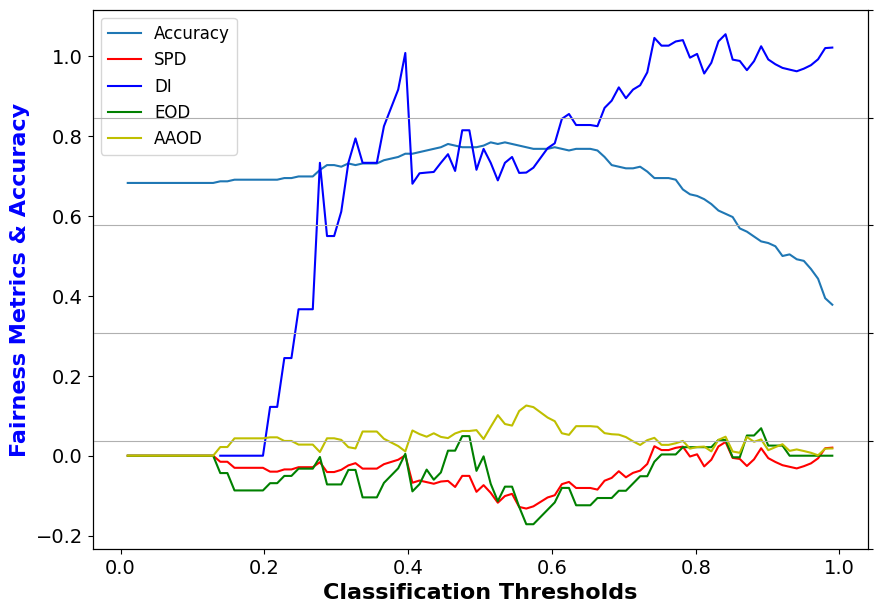

In [185]:
y_hat_proba_test = loan_model.predict_proba(X_test)


acc_arr_orig, spd_arr_orig, disp_imp_arr_orig, eod_arr_orig, aaod_arr_orig = search_threshold('Age<=40', X_test,
                                                                               y_hat_proba_test,
                                                                               y_test,
                                                                               0,
                                                                               1)


plot_trade(np.linspace(0.01, 0.99, 100), acc_arr_orig, spd_arr_orig, disp_imp_arr_orig, eod_arr_orig, aaod_arr_orig)

### Interpretation

Q: How do the fairness metrics and accuracy relate? Why? Choose the fairness metric that's the most important to this specific case study. How would you go about maximizing for both accuracy and the fairness metric? (4-6 sentences)


**Solution**





(简答题）

Q: Explore this [loan simulation case study](https://research.google.com/bigpicture/attacking-discrimination-in-ml/) which also deals with thresholding. Play with different thresholds and see what happens. In this case, how would you go about maximizing for both profit and fairness, and what threshold would you choose as a result of that approach? (4-6 sentences)

**Solution**



(简答题）

## Section 4b: Resampling

In this section, we want you to retrain the model using inputs that have a different ratio of elements in demographic groups and then see how the fairness measures change if at all. For instace, you could modify the frequency at which different groups appear in the training set.

We revisit the public health coverage dataset for the remaining parts of the assignment.

In [186]:
from folktables import ACSDataSource, ACSPublicCoverage
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# import data source form ACS
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
prediction_task = ACSPublicCoverage

# gather columns defined in the ACSPublicCoverage prediction task
features, label, group = prediction_task.df_to_numpy(acs_data)

# aggregate features and target variable into the same dataframe
acs_public_coverage_data = acs_data[prediction_task.features
                               + [prediction_task.target]]

###### Data summary ######
print(acs_public_coverage_data.head())
print("features used for predictions: "   + str(prediction_task.features))
print("group membership variable: "       + str(prediction_task.group))
print("the target variable of interest: " + str(prediction_task.target))

# split the data into training and testing sets
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)
model = train(X_train, y_train)
yhat = model.predict(X_test)

   AGEP  SCHL  MAR  SEX  DIS  ESP  CIT  MIG  MIL  ANC  NATIVITY  DEAR  DEYE  \
0    30  14.0    1    1    2  NaN    1  3.0  4.0    1         1     2     2   
1    18  14.0    5    2    2  NaN    1  1.0  4.0    1         1     2     2   
2    69  17.0    1    1    1  NaN    1  1.0  2.0    2         1     2     2   
3    25   1.0    5    1    1  NaN    1  1.0  4.0    1         1     1     2   
4    31  18.0    5    2    2  NaN    1  1.0  4.0    1         1     2     2   

   DREM    PINCP  ESR  ST  FER  RAC1P  PUBCOV  
0   2.0  48500.0  6.0   6  NaN      8       1  
1   2.0      0.0  6.0   6  2.0      1       2  
2   2.0  13100.0  6.0   6  NaN      9       1  
3   1.0      0.0  6.0   6  NaN      1       1  
4   2.0      0.0  6.0   6  2.0      1       1  
features used for predictions: ['AGEP', 'SCHL', 'MAR', 'SEX', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'PINCP', 'ESR', 'ST', 'FER', 'RAC1P']
group membership variable: RAC1P
the target variable of int

Several approaches for resampling are detailed in [Kamiran and Kalders 2012, Data preprocessing techniques for classification without discrimination](https://link.springer.com/article/10.1007/s10115-011-0463-8). We recommend implementing the Uniform Sampling method described in Algorithm 4 of the paper, but feel free to use any other viable method. In particular, Section 5.3 details the partitioning of the dataset into various groups of interest. We want to rebalance these groups but keep the total number of data points we train on to remain the same, so some data points will be skipped and others will be duplicated. As such, we must calculate the sample weights according to the formulas described in the paper for these different groups.

In [187]:
### Weighting approach ###
def compute_sample_weight(y, group):
  """
  Computes sample weights according to the algorithm described in the paper.

  Args:
    y     (np.ndarray): Training labels.
    group (np.ndarray): Array of indices corresponding to group membership.

  Returns:
    list: sample weight
    dict: weight dict
  """
  assert(len(y) == len(group))

  # TODO: calculate sample weight

  total_samples = len(y)
  total_groups = len(np.unique(group))
  obs_probs = {}
  for g in np.unique(group):
      for c in np.unique(y):
          obs_probs[(g, c)] = np.sum((group == g) & (y == c)) / total_samples
  exp_prob_per_class = 1 / len(np.unique(y))
  exp_probs = {(g, c): exp_prob_per_class for g in np.unique(group) for c in np.unique(y)}
  weight_dict = {g: 1 / total_groups for g in np.unique(group)}
  sample_weight = [exp_probs[(group[i], y[i])] / obs_probs[(group[i], y[i])] for i in range(total_samples)]

  return sample_weight, weight_dict

# NOTE: We will later use sample_weight in cost-sensitive training
#       and weight_dict in uniform sampling
sample_weight, weight_dict = compute_sample_weight(y_train, group_train)

In the Uniform Sampling method, the chance of sampling any given point within a group is uniform. As described in the paper, "all the data objects of the same group have the same
chance of being duplicated or skipped".

In [188]:
### Uniform sampling ###
def uniform_sampling(X, y, group, weight_dict):
  """
  Perform uniform sampling given a `weight_dict`

  Args:
    X     (np.ndarray): Training data.
    y     (np.ndarray): Training labels.
    group (np.ndarray): Array of indices corresponding to group membership.
    weight_dict (dict): Dict containing weights for different groups.

  Returns:
    np.ndarray: Sampled training data
    np.ndarray: Corresponding sampled training labels
    np.ndarray: Corresponding sampled array of group membership
  """

  # TODO: perform uniform sampling

  X_sampled = np.array([])
  y_sampled = np.array([])
  group_sampled = np.array([])

  X_sampled_list=[]
  y_sampled_list=[]
  group_sampled_list=[]
  for g, weight in weight_dict.items():
      group_indices = np.where(group == g)[0]
      if len(group_indices) == 0:
          continue
      num_samples = int(weight * len(X))
      indices = np.random.choice(np.where(group == g)[0], size=num_samples, replace=True)
      X_sampled_list.append(X[indices])
      y_sampled_list.append(y[indices])
      group_sampled_list.append(group[indices])
      X_sampled = np.concatenate(X_sampled_list)
      y_sampled = np.concatenate(y_sampled_list)
      group_sampled = np.concatenate(group_sampled_list)
      X=X_sampled
      y=y_sampled
      group=group_sampled

  p = np.random.permutation(len(X))
  X = X[p]
  y = y[p]
  group = group[p]



  return X_sampled, y_sampled, group_sampled

# Sample from training data
X_sampled, y_sampled, group_sampled = uniform_sampling(X_train, y_train, group_train, weight_dict)

model = train(X_sampled, y_sampled)
yhat = model.predict(X_test)
eval(yhat, y_test, group_test, "uniform_sampling")

Results from the uniform_sampling model: 
the indepence of prediction and group is  1.1141774037852834
the true positive separation is  1.012398507790213
the false positive separation is  1.1286037365925807
the sufficiency of the prediction and the group is 1.2399584500110776


## Section 4c: Cost-Sensitive Learning

Train the model using a different measure of cost (not accuracy, but cost-sensitive accuracy) and see what happens to the output.

It may be helpful to look at the documentation for the `LogisticRegression` classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html.


In [189]:
def train_weighted(X_train, y_train):
  """
  Defines and trains a logistic regression model on the training data.
  Applies weighting on training the model.

  Args:
    X_train (np.ndarray): Training inputs.
    y_train (np.ndarray): Training labels.

  Returns:
    sklearn.pipeline.Pipeline: trained model
  """

  clf = LogisticRegression(class_weight='balanced')
  scaler = StandardScaler()
  # TODO: train model
  model=make_pipeline(scaler,clf)
  model.fit(X_train,y_train)
  return model


In [190]:
weighted_model = train_weighted(X_train, y_train)
yhat = weighted_model.predict(X_test)

print("Results from a model trained with weighting approach: ")
print(independence(yhat, group_test))
print(separation(yhat, y_test, group_test))
print(sufficiency(yhat, y_test, group_test))

Results from a model trained with weighting approach: 
1.3277049298614207
(1.0889271371199083, 1.5007461191928937)
1.1191987998981046


## Section 5: Feedback

**Questions:** How long did you spend on this assignment? Were there any questions that you felt were especially challenging or could have been explained better?

Is there anything about the assignment or the course currently that you wish could be improved?

Edit this cell to type in your response below:

> Indented block



# Submission Instructions
Please submit this Colab as **two** files to Gradescope:
1.   A `.py` file: Click File > Download > Download .py
2.   A `.ipynb` file with outputs: Click Runtime > Run All, and then after all outputs are complete, click File > Download > Download .ipynb

Please ensure that the `.ipynb` contains actual function outputs (and not leftover print statements, for instance). We will run your `.ipynb` file; if our outputs don't match the outputs in your submitted file (within reason), you will receive a 0 on this assignment.